In [24]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score
)
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score
)


In [25]:
import sys
from pathlib import Path


sys.path.append(str(Path('../../../code/myModels').resolve()))

from clarans import MyCLARANS

In [26]:
merged_dir = "../../../data/merged"
image_dir = "../../../images/CLARANS"

In [27]:
fire_file_path = os.path.join(merged_dir, "fire_land_elev_soil_climate.parquet")
data = pd.read_parquet(fire_file_path)
X = data.drop(columns=['fire','longitude', 'latitude'])
y = data['fire']

In [28]:
# use one hot encoding on LCCCode
X = pd.get_dummies(X, columns=['LCCCode'], drop_first=True)
# Check dtypes again
print(X.dtypes)
# check nan
print(X.isna().sum())

elevation                                  int64
COARSE                                   float64
SAND                                     float64
CLAY                                     float64
TCARBON_EQ                               float64
PH_WATER                                 float64
TOTAL_N                                  float64
CN_RATIO                                 float64
CEC_SOIL                                 float64
ESP                                      float64
GYPSUM                                   float64
prec_median_autumn                       float64
prec_median_spring                       float64
prec_median_summer                       float64
prec_median_winter                       float64
tmin_median_autumn                       float64
tmin_median_spring                       float64
tmin_median_summer                       float64
tmin_median_winter                       float64
tmax_median_autumn                       float64
tmax_median_spring  

In [29]:
param_grid = {
    "n_clusters": [2, 3, 4, 5],
    "num_local": [3, 5, 10],
    "max_neighbor": [20, 50, 100],
    "use_robust_scaler": [True, False]
}


In [30]:
results = []

for k in param_grid["n_clusters"]:
    for num_local in param_grid["num_local"]:
        for max_neighbor in param_grid["max_neighbor"]:
            for use_scaler in param_grid["use_robust_scaler"]:

                # -------- Preprocessing --------
                if use_scaler:
                    X_proc = RobustScaler().fit_transform(X)
                else:
                    X_proc = np.asarray(X, dtype=np. float64)

                # -------- Fit CLARANS --------
                clarans = MyCLARANS(
                    n_clusters=k,
                    num_local=num_local,
                    max_neighbor=max_neighbor,
                    random_state=42,
                    verbose=False
                )
                clarans.fit(X_proc)

                labels = clarans.labels_
                inertia = clarans.best_cost_  # CLARANS equivalent

                # -------- Metrics --------
                if len(np.unique(labels)) > 1:
                    sil = silhouette_score(X_proc, labels)
                    ch  = calinski_harabasz_score(X_proc, labels)
                    db  = davies_bouldin_score(X_proc, labels)
                else:
                    sil = ch = db = np.nan

                # -------- Save --------
                results.append({
                    "k": k,
                    "num_local": num_local,
                    "max_neighbor": max_neighbor,
                    "robust_scaler": use_scaler,
                    "inertia": inertia,
                    "silhouette": sil,
                    "calinski_harabasz": ch,
                    "davies_bouldin": db
                })

                print(
                    f"k={k}, local={num_local}, neigh={max_neighbor}, "
                    f"scaler={use_scaler} | "
                    f"sil={sil:.3f}, CH={ch:.1f}, DB={db:.3f}"
                )

df_results = pd.DataFrame(results)


k=2, local=3, neigh=20, scaler=True | sil=0.808, CH=74637.7, DB=0.330
k=2, local=3, neigh=20, scaler=False | sil=0.654, CH=137464.6, DB=0.454
k=2, local=3, neigh=50, scaler=True | sil=0.808, CH=74637.7, DB=0.330
k=2, local=3, neigh=50, scaler=False | sil=0.659, CH=143255.7, DB=0.456
k=2, local=3, neigh=100, scaler=True | sil=0.808, CH=74637.7, DB=0.330
k=2, local=3, neigh=100, scaler=False | sil=0.658, CH=141830.6, DB=0.455
k=2, local=5, neigh=20, scaler=True | sil=0.801, CH=73337.6, DB=0.371
k=2, local=5, neigh=20, scaler=False | sil=0.660, CH=143987.1, DB=0.457
k=2, local=5, neigh=50, scaler=True | sil=0.808, CH=74637.7, DB=0.330
k=2, local=5, neigh=50, scaler=False | sil=0.659, CH=143255.7, DB=0.456
k=2, local=5, neigh=100, scaler=True | sil=0.808, CH=74637.7, DB=0.330
k=2, local=5, neigh=100, scaler=False | sil=0.658, CH=141830.6, DB=0.455
k=2, local=10, neigh=20, scaler=True | sil=0.801, CH=73337.6, DB=0.371
k=2, local=10, neigh=20, scaler=False | sil=0.658, CH=141416.7, DB=0.455


In [31]:
df_ranked = df_results.copy()

df_ranked["rank_sil"] = df_ranked["silhouette"].rank(ascending=False)
df_ranked["rank_ch"]  = df_ranked["calinski_harabasz"].rank(ascending=False)
df_ranked["rank_db"]  = df_ranked["davies_bouldin"].rank(ascending=True)
df_ranked["rank_in"]  = df_ranked["inertia"].rank(ascending=True)

df_ranked["total_rank"] = (
    df_ranked["rank_sil"] +
    df_ranked["rank_ch"] +
    df_ranked["rank_db"] +
    df_ranked["rank_in"]
)

best = df_ranked.sort_values("total_rank").iloc[0]
print("\n🏆 Best configuration:")
print(best)



🏆 Best configuration:
k                                2
num_local                        3
max_neighbor                    50
robust_scaler                 True
inertia              278528.628081
silhouette                0.808146
calinski_harabasz     74637.743487
davies_bouldin            0.330342
rank_sil                       4.0
rank_ch                       40.0
rank_db                        4.0
rank_in                       29.0
total_rank                    77.0
Name: 2, dtype: object


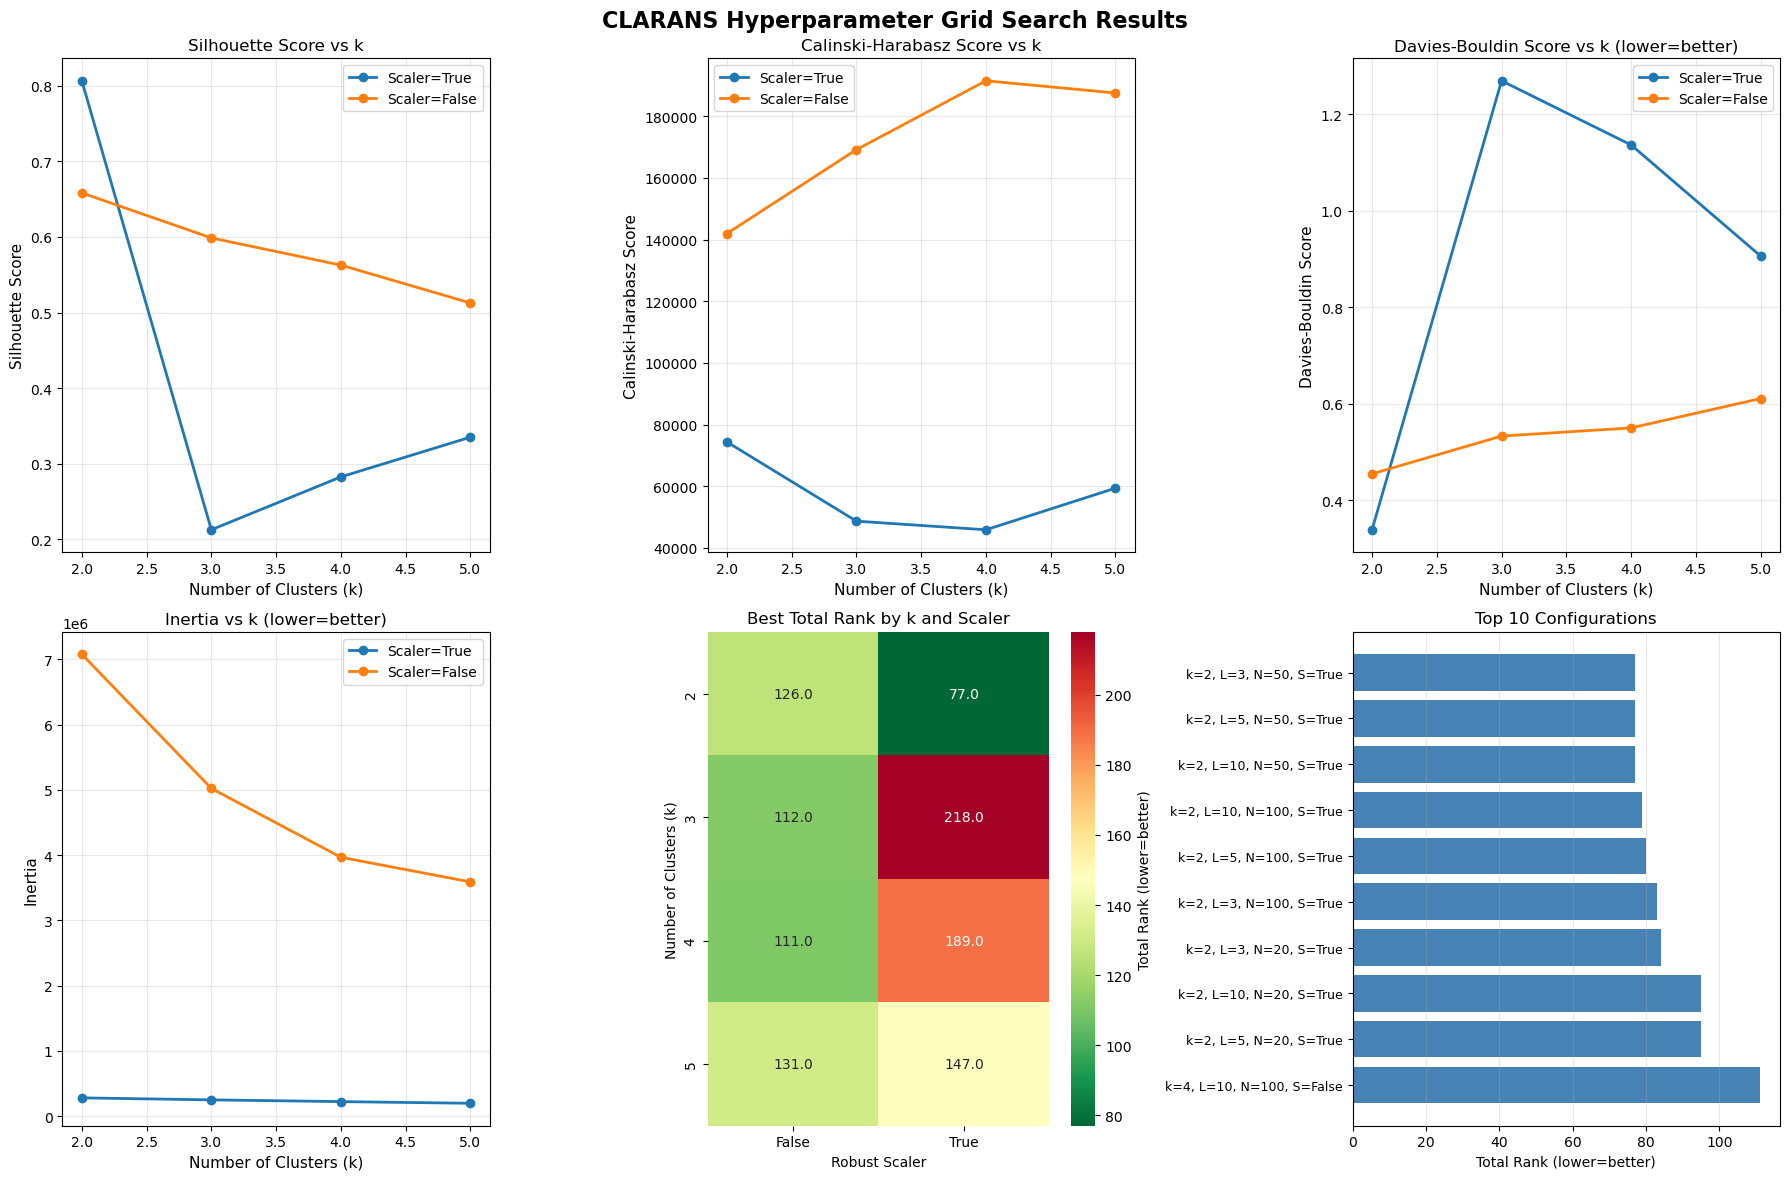


🏆 Best configuration:
k = 2
num_local = 3
max_neighbor = 50
robust_scaler = True

Metrics:
  Silhouette: 0.8081
  Calinski-Harabasz: 74637.74
  Davies-Bouldin: 0.3303
  Inertia: 278528.63


In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('CLARANS Hyperparameter Grid Search Results', fontsize=16, fontweight='bold')

# 1. Silhouette Score by k and scaler
ax1 = axes[0, 0]
for scaler in df_results["robust_scaler"]. unique():
    subset = df_results[df_results["robust_scaler"] == scaler]
    grouped = subset.groupby("k")["silhouette"].mean()
    ax1.plot(grouped. index, grouped.values, marker='o', 
             label=f'Scaler={scaler}', linewidth=2)
ax1.set_xlabel('Number of Clusters (k)', fontsize=11)
ax1.set_ylabel('Silhouette Score', fontsize=11)
ax1.set_title('Silhouette Score vs k')
ax1.legend()
ax1.grid(alpha=0.3)

# 2. Calinski-Harabasz Score
ax2 = axes[0, 1]
for scaler in df_results["robust_scaler"].unique():
    subset = df_results[df_results["robust_scaler"] == scaler]
    grouped = subset.groupby("k")["calinski_harabasz"].mean()
    ax2.plot(grouped.index, grouped.values, marker='o', 
             label=f'Scaler={scaler}', linewidth=2)
ax2.set_xlabel('Number of Clusters (k)', fontsize=11)
ax2.set_ylabel('Calinski-Harabasz Score', fontsize=11)
ax2.set_title('Calinski-Harabasz Score vs k')
ax2.legend()
ax2.grid(alpha=0.3)

# 3. Davies-Bouldin Score (lower is better)
ax3 = axes[0, 2]
for scaler in df_results["robust_scaler"].unique():
    subset = df_results[df_results["robust_scaler"] == scaler]
    grouped = subset.groupby("k")["davies_bouldin"].mean()
    ax3.plot(grouped.index, grouped.values, marker='o', 
             label=f'Scaler={scaler}', linewidth=2)
ax3.set_xlabel('Number of Clusters (k)', fontsize=11)
ax3.set_ylabel('Davies-Bouldin Score', fontsize=11)
ax3.set_title('Davies-Bouldin Score vs k (lower=better)')
ax3.legend()
ax3.grid(alpha=0.3)

# 4. Inertia
ax4 = axes[1, 0]
for scaler in df_results["robust_scaler"].unique():
    subset = df_results[df_results["robust_scaler"] == scaler]
    grouped = subset.groupby("k")["inertia"].mean()
    ax4.plot(grouped.index, grouped.values, marker='o', 
             label=f'Scaler={scaler}', linewidth=2)
ax4.set_xlabel('Number of Clusters (k)', fontsize=11)
ax4.set_ylabel('Inertia', fontsize=11)
ax4.set_title('Inertia vs k (lower=better)')
ax4.legend()
ax4.grid(alpha=0.3)

# 5. Heatmap of Total Rank by parameters
ax5 = axes[1, 1]
pivot = df_ranked.pivot_table(
    values='total_rank', 
    index='k', 
    columns='robust_scaler', 
    aggfunc='min'
)
sns.heatmap(pivot, annot=True, fmt='.1f', cmap='RdYlGn_r', 
            ax=ax5, cbar_kws={'label': 'Total Rank (lower=better)'})
ax5.set_title('Best Total Rank by k and Scaler')
ax5.set_xlabel('Robust Scaler')
ax5.set_ylabel('Number of Clusters (k)')

# 6. Top 10 configurations
ax6 = axes[1, 2]
top10 = df_ranked.sort_values("total_rank").head(10)
y_pos = np.arange(len(top10))
ax6.barh(y_pos, top10["total_rank"], color='steelblue')
ax6.set_yticks(y_pos)
labels = [f"k={int(row. k)}, L={int(row.num_local)}, N={int(row.max_neighbor)}, S={row.robust_scaler}" 
          for _, row in top10.iterrows()]
ax6.set_yticklabels(labels, fontsize=9)
ax6.invert_yaxis()
ax6.set_xlabel('Total Rank (lower=better)')
ax6.set_title('Top 10 Configurations')
ax6.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Print best configuration
print("\n🏆 Best configuration:")
print(f"k = {int(best['k'])}")
print(f"num_local = {int(best['num_local'])}")
print(f"max_neighbor = {int(best['max_neighbor'])}")
print(f"robust_scaler = {best['robust_scaler']}")
print(f"\nMetrics:")
print(f"  Silhouette: {best['silhouette']:.4f}")
print(f"  Calinski-Harabasz: {best['calinski_harabasz']:.2f}")
print(f"  Davies-Bouldin: {best['davies_bouldin']:.4f}")
print(f"  Inertia: {best['inertia']:.2f}")

[Local 1] Initial cost = 387889.9888
  ↓ Improved cost = 366205.4573
  ↓ Improved cost = 362537.2081
  ↓ Improved cost = 357351.7907
  ↓ Improved cost = 355420.3568
  ↓ Improved cost = 340326.1527
  ↓ Improved cost = 312320.6784
  ↓ Improved cost = 306744.1508
  ↓ Improved cost = 292804.8283
  ↓ Improved cost = 292735.6246
  ↓ Improved cost = 284529.9267
  ↓ Improved cost = 284264.2208
[Local 2] Initial cost = 327216.7273
  ↓ Improved cost = 306238.3026
  ↓ Improved cost = 299400.1808
[Local 3] Initial cost = 341509.9666
  ↓ Improved cost = 337638.8944
  ↓ Improved cost = 292460.6665
  ↓ Improved cost = 291793.5046
  ↓ Improved cost = 284639.0083
  ↓ Improved cost = 278528.6281


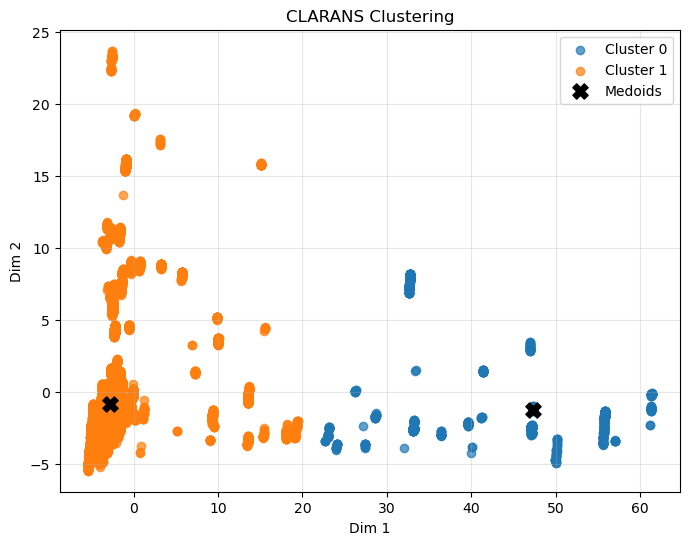

In [40]:
X_best = RobustScaler().fit_transform(X) if best["robust_scaler"] else X.copy()

best_model = MyCLARANS(
    n_clusters=int(best["k"]),
    num_local=int(best["num_local"]),
    max_neighbor=int(best["max_neighbor"]),
    random_state=42,
    verbose=True
)

best_model.fit(X_best)
best_model.plot_clusters(X_best)


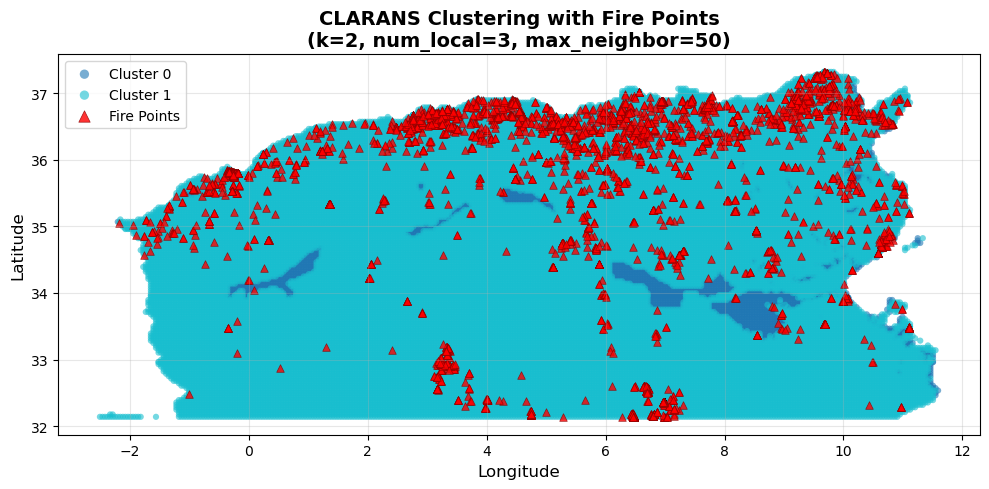

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# Get cluster labels from best model
cluster_labels = best_model.labels_

# Create figure with map
fig, ax = plt.subplots(figsize=(10, 5))

# Get unique clusters
unique_clusters = np.unique(cluster_labels)
n_clusters = len(unique_clusters)

# Create color map for clusters
colors = plt.cm.tab10(np.linspace(0, 1, n_clusters))

# Plot each cluster
for i, cluster in enumerate(unique_clusters):
    mask = cluster_labels == cluster
    ax.scatter(
        data. loc[mask, 'longitude'],
        data.loc[mask, 'latitude'],
        c=[colors[i]],
        label=f'Cluster {cluster}',
        alpha=0.6,
        s=20,
        edgecolors='none'
    )

# Overlay fire points in red
fire_mask = y == 1
ax.scatter(
    data.loc[fire_mask, 'longitude'],
    data.loc[fire_mask, 'latitude'],
    c='red',
    label='Fire Points',
    alpha=0.8,
    s=30,
    marker='^',
    edgecolors='darkred',
    linewidths=0.5
)

ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
ax.set_title(f'CLARANS Clustering with Fire Points\n(k={int(best["k"])}, num_local={int(best["num_local"])}, max_neighbor={int(best["max_neighbor"])})',
             fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10, markerscale=1.5)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()



In [44]:
# Percentage of fire points in each cluster
cluster_fire_percentages = {}
unique_clusters = np.unique(cluster_labels)

for cluster in unique_clusters:  
    cluster_mask = cluster_labels == cluster
    total_points = np.sum(cluster_mask)
    
    # Handle both numpy array and pandas Series for y
    if isinstance(y, pd.Series):
        fire_points = np.sum(y.values[cluster_mask] == 1)
    else:
        fire_points = np.sum(y[cluster_mask] == 1)
    
    percentage_fire = (fire_points / total_points) * 100 if total_points > 0 else 0
    cluster_fire_percentages[cluster] = {
        'total_points': total_points,
        'fire_points': fire_points,
        'percentage':  percentage_fire
    }

# Display results
print("\n" + "="*70)
print("🔥 FIRE DISTRIBUTION ANALYSIS BY CLUSTER")
print("="*70)

for cluster in sorted(cluster_fire_percentages.keys()):
    stats = cluster_fire_percentages[cluster]
    print(f"\nCluster {cluster}:")
    print(f"  Total points:     {stats['total_points']:,}")
    print(f"  Fire points:      {stats['fire_points']:,}")
    print(f"  Fire percentage:   {stats['percentage']:.2f}%")
    print(f"  No-fire points:   {stats['total_points'] - stats['fire_points']:,}")

# Overall statistics
total_all = len(y)
fire_all = np.sum(y == 1) if isinstance(y, np.ndarray) else np.sum(y.values == 1)
print("\n" + "-"*70)
print(f"Overall Dataset:")
print(f"  Total points:     {total_all:,}")
print(f"  Fire points:       {fire_all:,}")
print(f"  Fire percentage:  {(fire_all/total_all)*100:.2f}%")
print("="*70)


🔥 FIRE DISTRIBUTION ANALYSIS BY CLUSTER

Cluster 0:
  Total points:     1,796
  Fire points:      63
  Fire percentage:   3.51%
  No-fire points:   1,733

Cluster 1:
  Total points:     40,495
  Fire points:      4,353
  Fire percentage:   10.75%
  No-fire points:   36,142

----------------------------------------------------------------------
Overall Dataset:
  Total points:     42,291
  Fire points:       4,416
  Fire percentage:  10.44%
